⏳ Fetching data from BigQuery...


/usr/local/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✅ Loaded 228 rows.


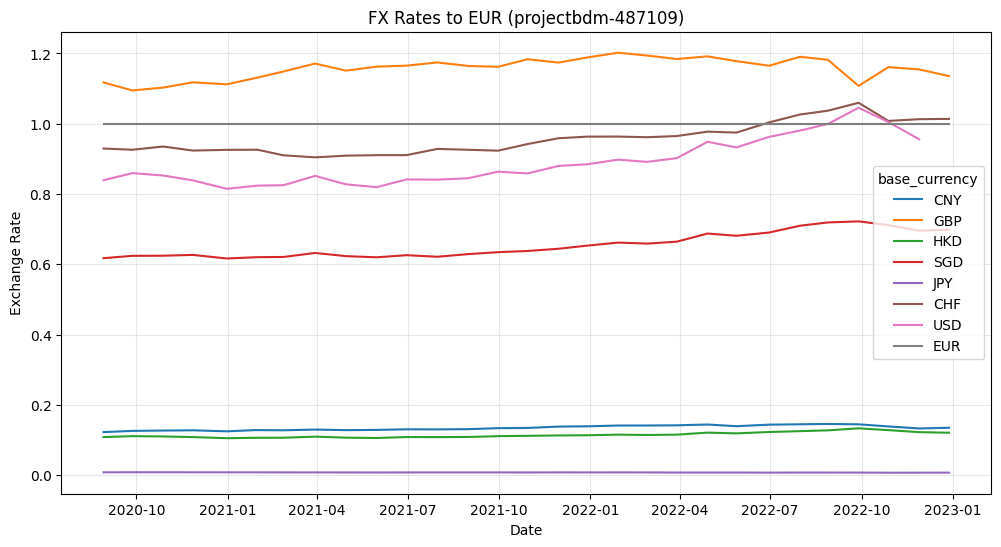

In [ ]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Client
# (Auth is handled automatically by the Docker env vars we set up)
client = bigquery.Client()

# Define Config (Using Project ID)
PROJECT_ID = os.environ.get("GOOGLE_CLOUD_PROJECT", "projectbdm-487109")
DATASET = "patek_data"
TABLE = "fx_rates"

# Query the Data
query = f"""
    SELECT date, base_currency, rate
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
    WHERE target_currency = 'EUR'
    ORDER BY date
"""

print("⏳ Fetching data from BigQuery...")
df = client.query(query).to_dataframe()

# Fix types
df['date'] = pd.to_datetime(df['date'])
df['rate'] = df['rate'].astype(float)

print(f"✅ Loaded {len(df)} rows.")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='rate', hue='base_currency')
plt.title(f"FX Rates to EUR ({PROJECT_ID})")
plt.ylabel("Exchange Rate")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()